In [1]:
import os
import numpy as np
import glob
from tqdm import tqdm
import copy
from skimage.feature import canny
from skimage.transform import resize
import pandas as pd
import seaborn as sns
import nibabel as nib

# from torchinfo import summary

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torchio as tio
import networks_gan
import losses
from skimage.metrics import structural_similarity as ssim
from dataloader import RadOncTrainingDataset, RadOncValidationDataset, RadOncSynthesisDataset, headscanner_training_dataset, headscanner_validation_dataset
import surface_distance
from helpers import compute_surface_metrics, compute_TRE
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm  # nopep8

import matplotlib.pyplot as plt
from matplotlib import colors as mplcolors
from matplotlib.collections import LineCollection
def colormap_binary(fg, bg=(0,0,0), alpha=None):
    fg = mplcolors.to_rgb(fg)
    bg = mplcolors.to_rgb(bg)
    cmap = mplcolors.LinearSegmentedColormap.from_list('Binary', (bg,fg), 256)
    if alpha is not None:
        cmap._init()
        cmap._lut[:,-1] = np.linspace(0, alpha, cmap.N+3)
    return cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')

2023-12-11 16:19:59.747662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 16:19:59.895643: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 16:19:59.899202: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-11 16:19:59.899216: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
valid_dataset = RadOncValidationDataset("/home/myi16/jsr_Y/md4_val", num_samples=None, supervision=True,
                                            return_segmentation=True)
device = 'cpu'

In [8]:
class MIND:
    """
    Modality-Independent NeighborHood Descriptor
    """

    def __init__(self, vol_size, d, patch_size, use_ssc=False, use_gaussian_kernel=False,
                 use_fixed_var=True, device='cuda'):
        self.epsilon = 0.000001
        self.vol_size = vol_size
        self.d = d
        self.patch_size = patch_size
        self.use_ssc = use_ssc
        self.use_gaussian_kernel = use_gaussian_kernel
        self.use_fixed_var = use_fixed_var

        if use_gaussian_kernel:
            dist = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

            vals = torch.exp(dist.log_prob(torch.arange(-(patch_size - 1) / 2, (patch_size - 1) / 2 + 1)))
            kernel = torch.einsum('i,j,k->ijk', vals, vals, vals)
            kernel = kernel / torch.sum(kernel)
            self.kernel = kernel.unsqueeze(0).unsqueeze(0)
        else:
            self.kernel = torch.ones([1, 1, patch_size, patch_size, patch_size]) / (patch_size ** 3)
        self.kernel = self.kernel.to(device)

    def ssd_shift(self, image, direction):
        # expects a 3d image
        x, y, z = self.vol_size
        new_shift = np.clip(direction, 0, None)
        old_shift = -np.clip(direction, None, 0)

        # translate images
        new_image = image[:, :, new_shift[0]:x - old_shift[0], new_shift[1]:y - old_shift[1],
                    new_shift[2]:z - old_shift[2]]
        old_image = image[:, :, old_shift[0]:x - new_shift[0], old_shift[1]:y - new_shift[1],
                    old_shift[2]:z - new_shift[2]]
        # get squared difference
        diff = torch.square(new_image - old_image)

        # pad the diff
        # padding = np.concatenate((np.array([[0,0]]), np.transpose([old_shift, new_shift])))
        padding = (old_shift[2], new_shift[2], old_shift[1], new_shift[1], old_shift[0], new_shift[0])
        diff = F.pad(diff, padding)

        # apply convolution
        conv = F.conv3d(diff, self.kernel, padding=(self.patch_size // 2))
        return conv

    def mind_loss(self, y_true, y_pred):
        ndims = 3
        y_true = y_true
        y_pred = y_pred
        loss_tensor = 0

        if self.use_fixed_var:
            y_true_var = 0.004
            y_pred_var = 0.004
        else:
            y_true_var = 0
            y_pred_var = 0
            for i in range(ndims):
                direction = [0] * ndims
                direction[i] = self.d

                y_true_var += self.ssd_shift(y_true, direction)
                y_pred_var += self.ssd_shift(y_pred, direction)

                direction = [0] * ndims
                direction[i] = -self.d
                y_true_var += self.ssd_shift(y_true, direction)
                y_pred_var += self.ssd_shift(y_pred, direction)

            y_true_var = y_true_var / (ndims * 2) + self.epsilon
            y_pred_var = y_pred_var / (ndims * 2) + self.epsilon

        # print(y_true_var)
        for i in range(ndims):
            direction = [0] * ndims
            direction[i] = self.d

            loss_tensor += torch.mean(torch.abs(torch.exp(-self.ssd_shift(y_true, direction) / y_true_var)
                                                - torch.exp(-self.ssd_shift(y_pred, direction) / y_pred_var)))

            direction = [0] * ndims
            direction[i] = -self.d
            loss_tensor += torch.mean(torch.abs(torch.exp(-self.ssd_shift(y_true, direction) / y_true_var)
                                                - torch.exp(-self.ssd_shift(y_pred, direction) / y_pred_var)))

        return loss_tensor / (ndims * 2)

    def loss(self, y_true, y_pred):
        return self.mind_loss(y_true, y_pred)

In [2]:
valid_dataset = RadOncValidationDataset("/mnt/blackhole-data2/RadOnc_Brain/Validation", num_samples=None, supervision=True,
                                            return_segmentation=True)

device = torch.device('cpu')

In [6]:
G = networks_gan.JSRCascade(separate_decoders=True, res=True, version='v5').to(device)
checkpoint = torch.load('JSREDLuns_lastlayer_init_nosl_mix_l1100_unc0.1_inunc1_multi0.3_reg100_seg6_ep59.pt', map_location=torch.device('cpu'))
G.load_state_dict(checkpoint['G_state_dict'])

<All keys matched successfully>

10


  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.) tensor(0.1599)


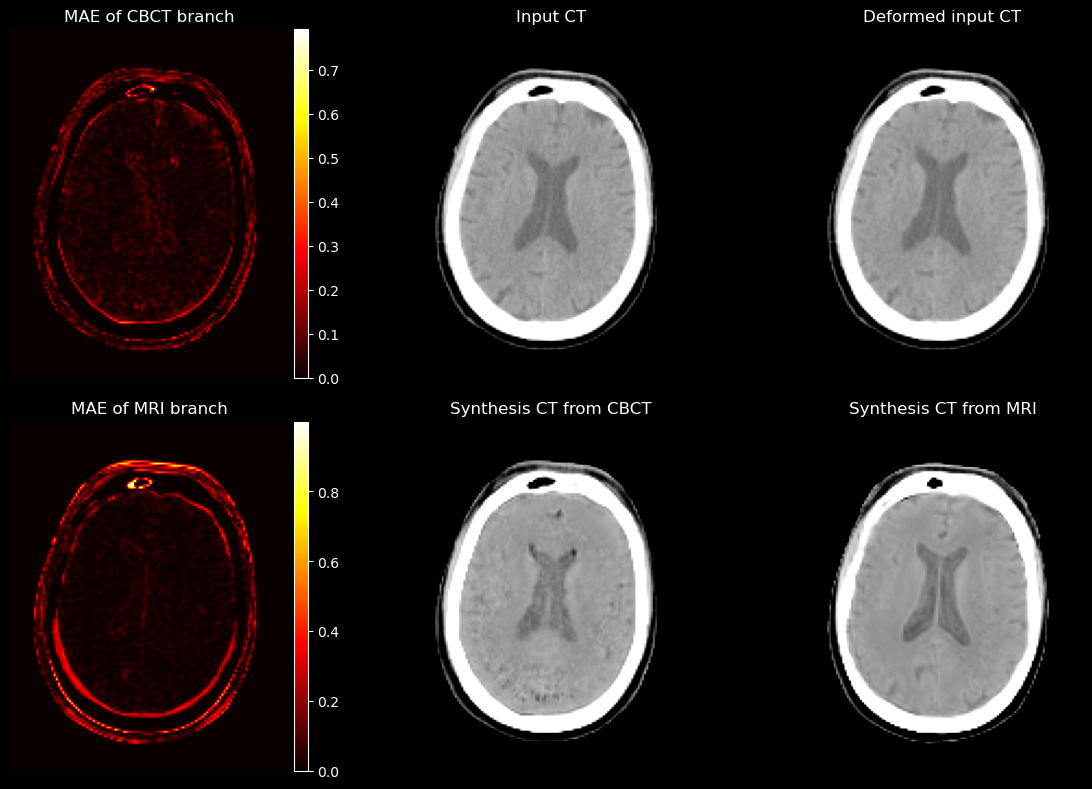

torch.Size([1, 7, 128, 160, 128])


 10%|█         | 1/10 [00:12<01:50, 12.29s/it]

tensor(0.) tensor(0.1586)


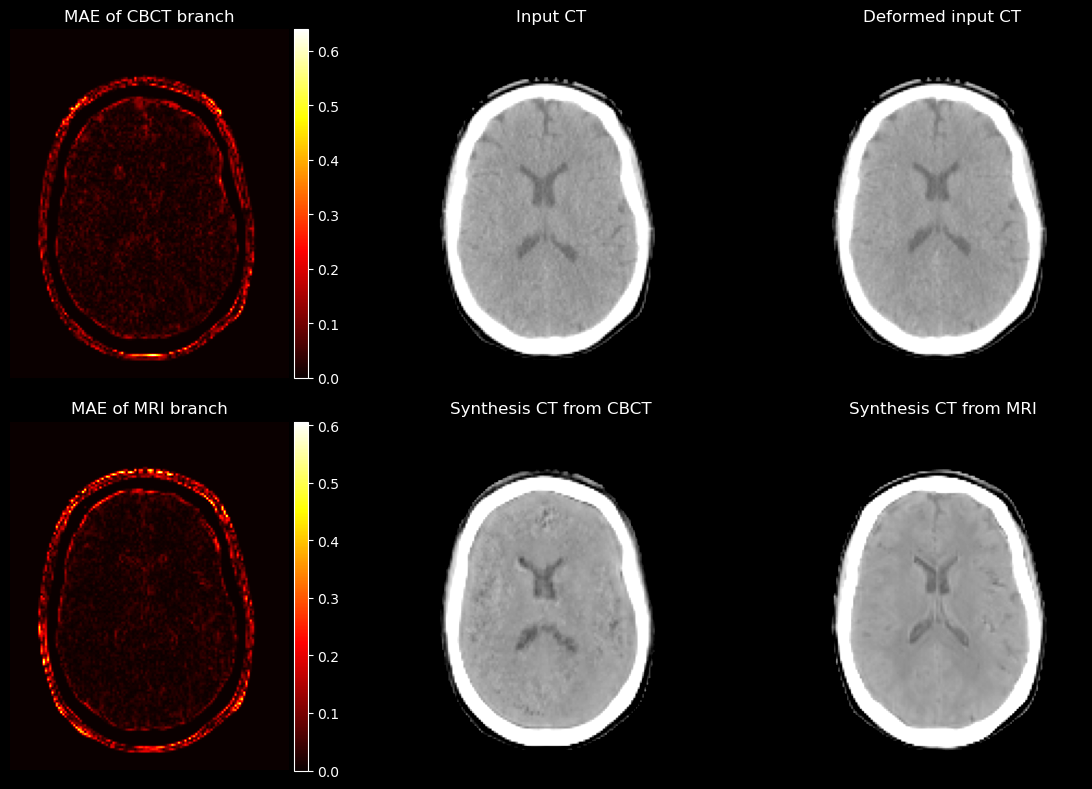

torch.Size([1, 7, 128, 160, 128])


 20%|██        | 2/10 [00:25<01:42, 12.75s/it]

tensor(0.) tensor(0.1746)


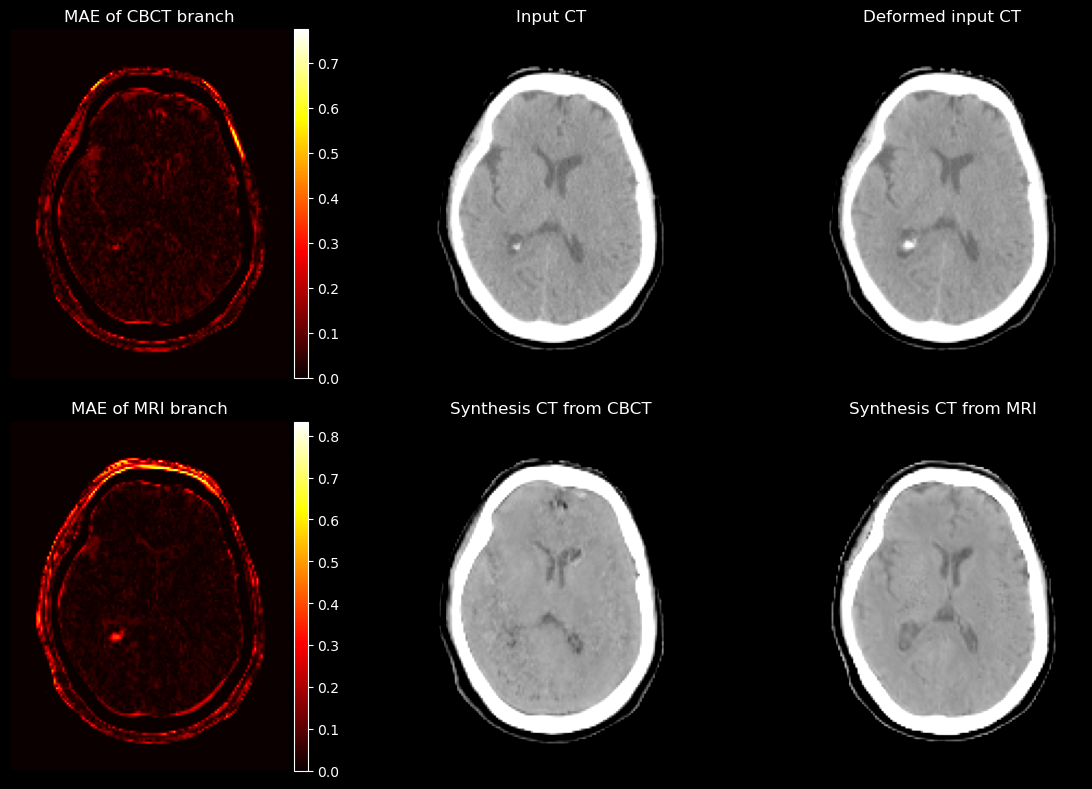

torch.Size([1, 7, 128, 160, 128])


 30%|███       | 3/10 [00:39<01:32, 13.23s/it]

tensor(0.) tensor(0.1542)


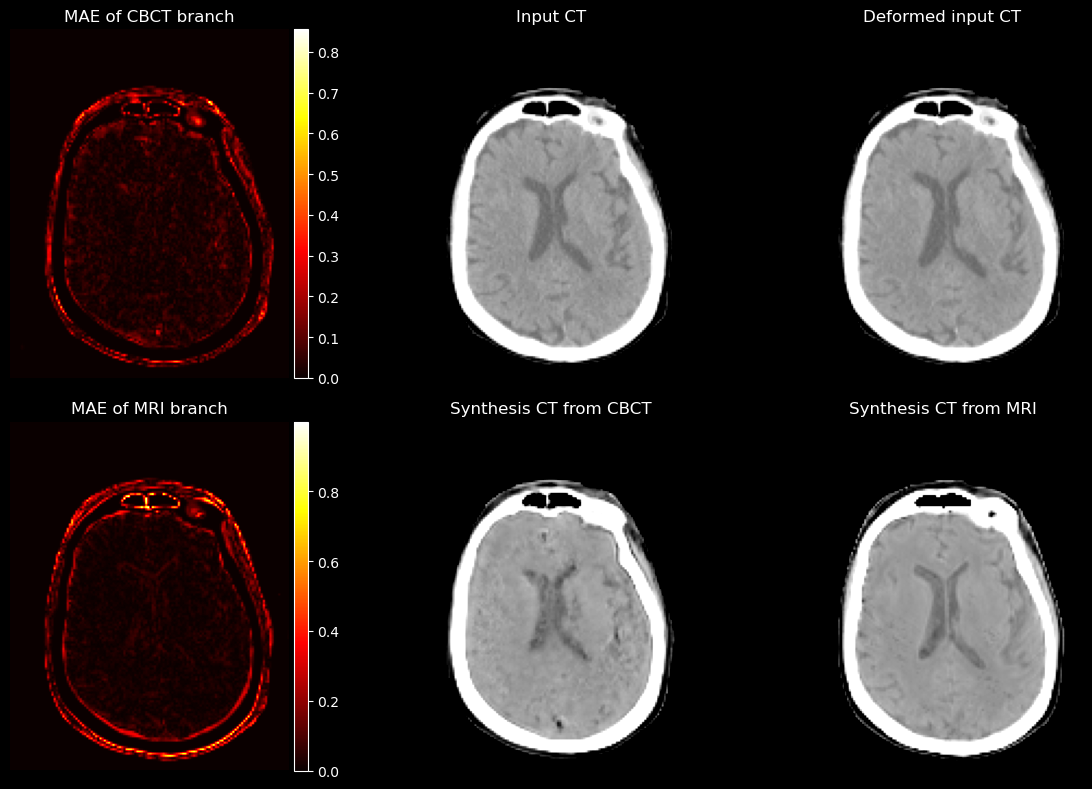

torch.Size([1, 7, 128, 160, 128])


 40%|████      | 4/10 [00:52<01:20, 13.44s/it]

tensor(0.) tensor(0.1362)


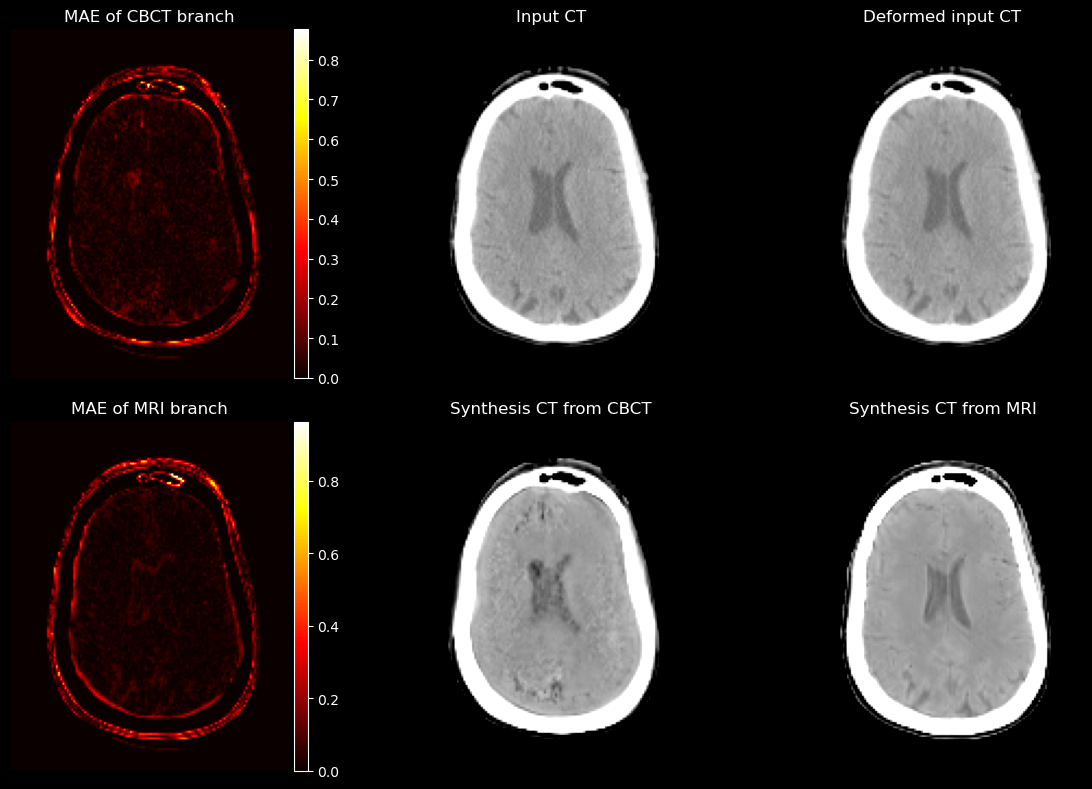

torch.Size([1, 7, 128, 160, 128])


 50%|█████     | 5/10 [01:05<01:05, 13.16s/it]

tensor(0.) tensor(0.1628)


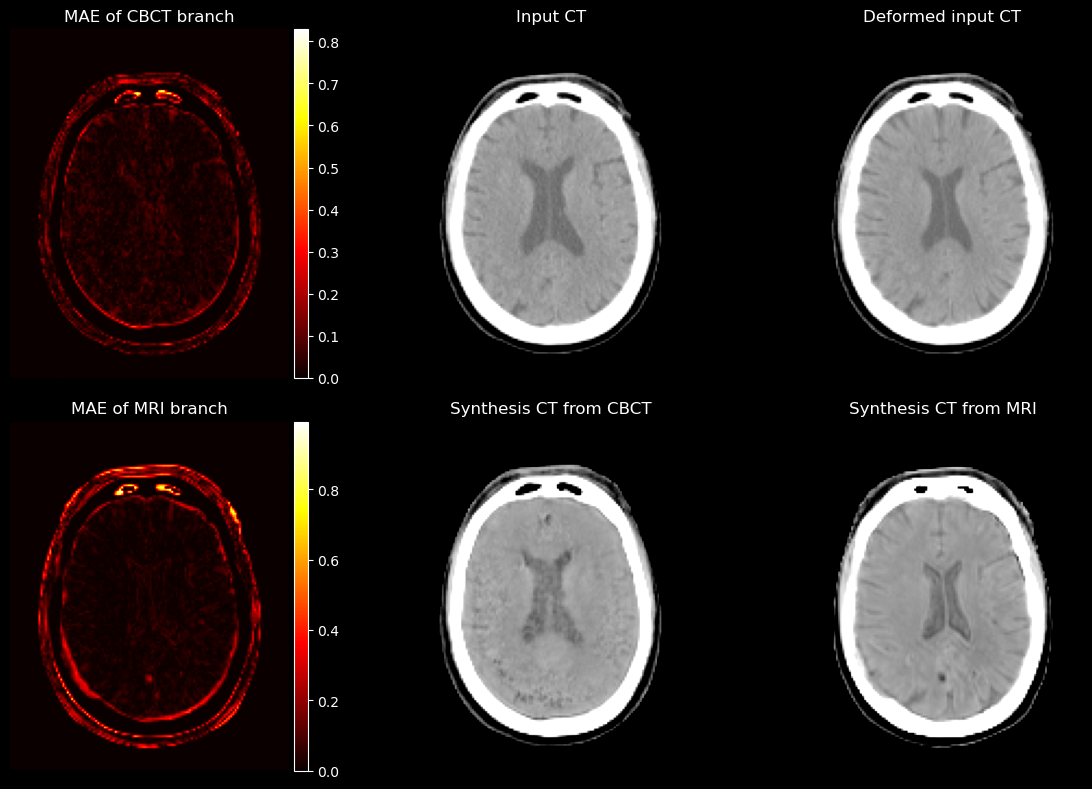

torch.Size([1, 7, 128, 160, 128])


 60%|██████    | 6/10 [01:19<00:53, 13.38s/it]

tensor(0.) tensor(0.1589)


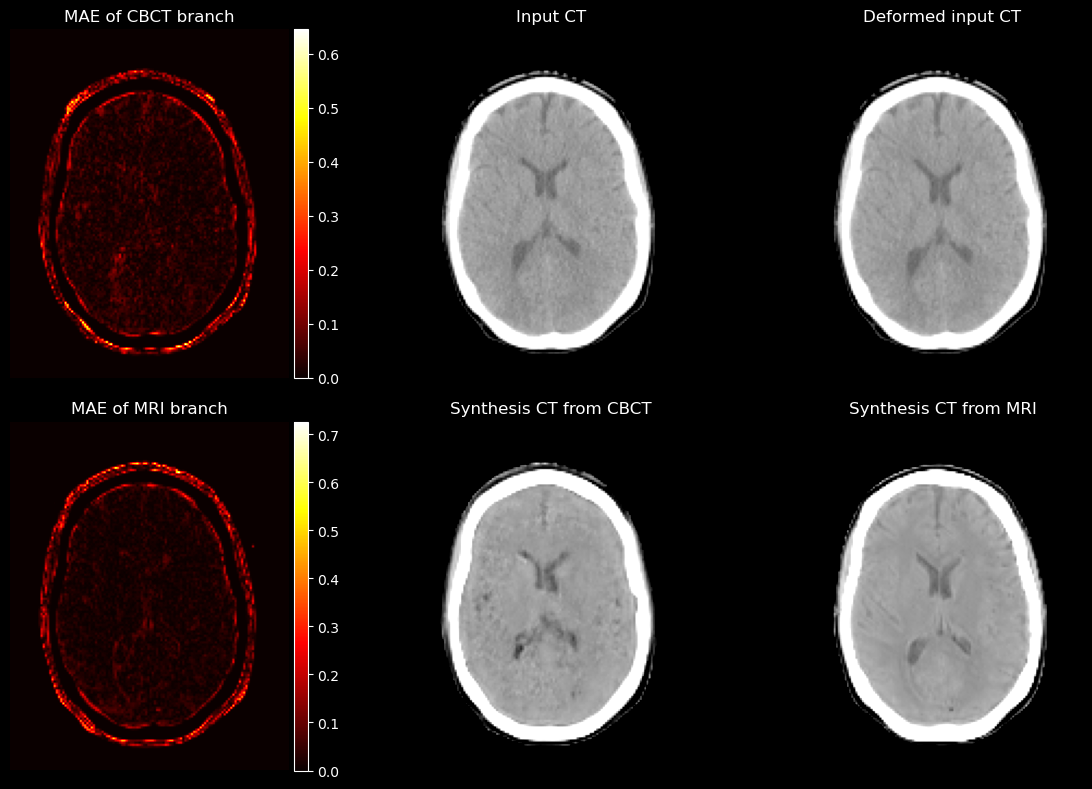

torch.Size([1, 7, 128, 160, 128])


 70%|███████   | 7/10 [01:32<00:39, 13.23s/it]

tensor(0.) tensor(0.1690)


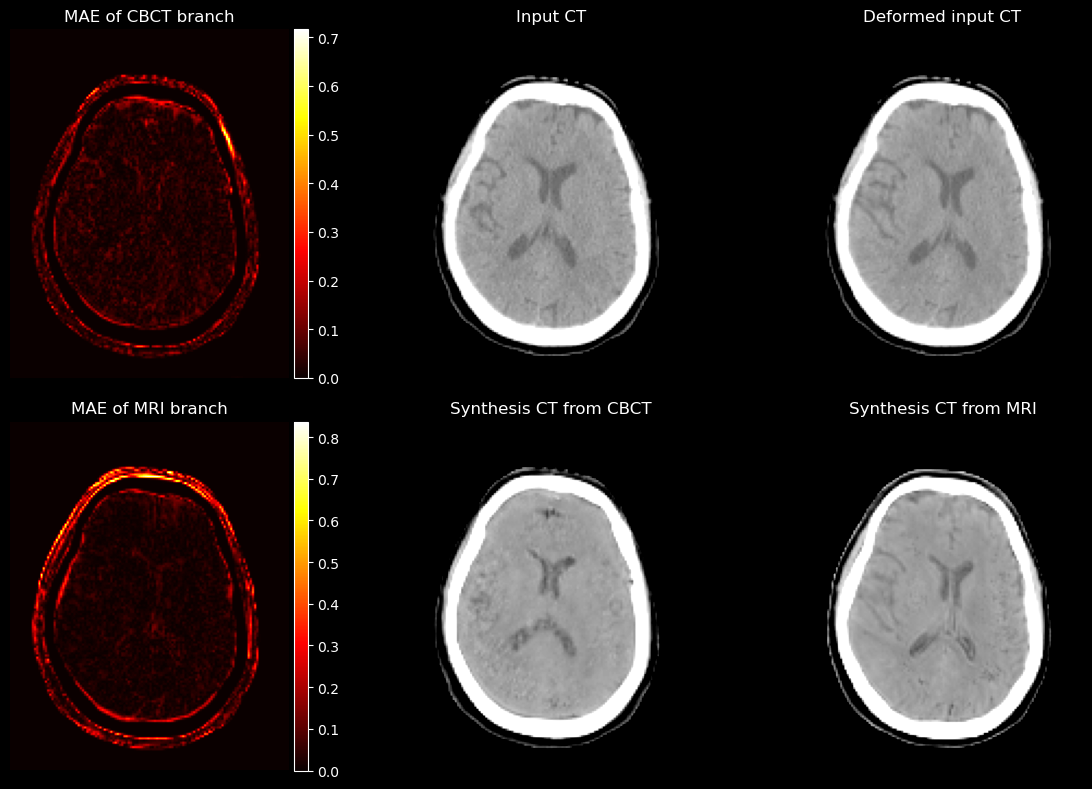

torch.Size([1, 7, 128, 160, 128])


 80%|████████  | 8/10 [01:44<00:25, 12.97s/it]

tensor(0.) tensor(0.1474)


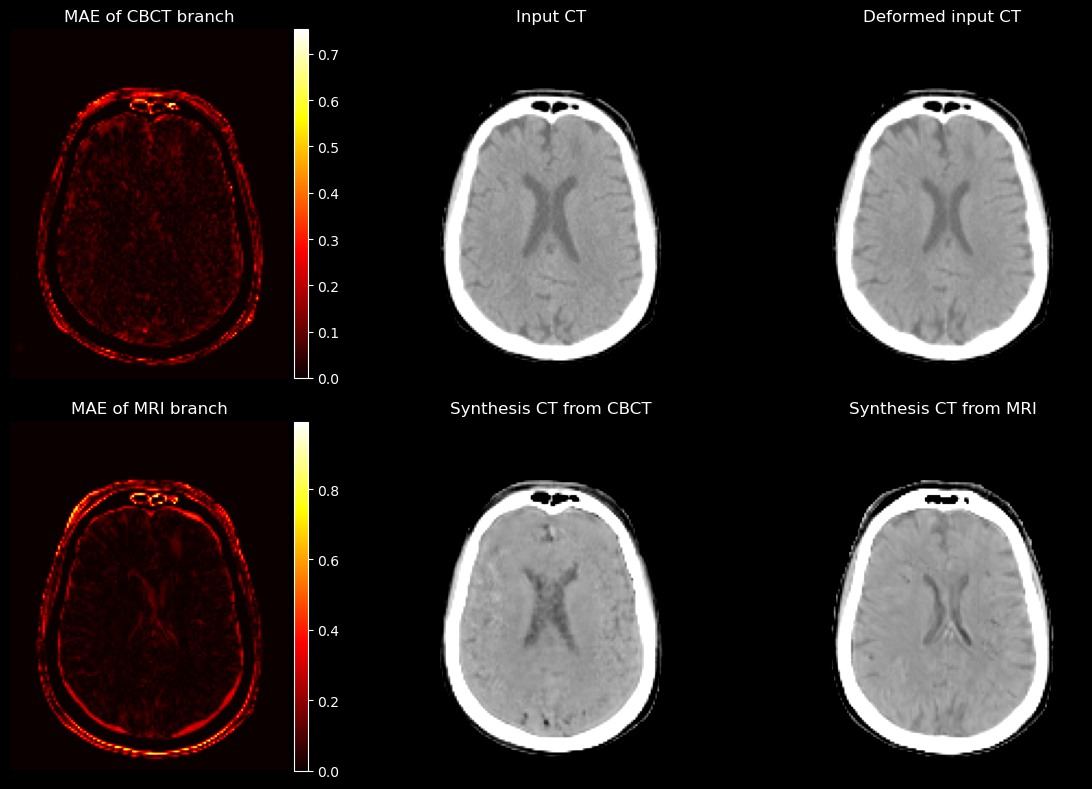

torch.Size([1, 7, 128, 160, 128])


 90%|█████████ | 9/10 [01:58<00:13, 13.20s/it]

tensor(0.) tensor(0.1353)


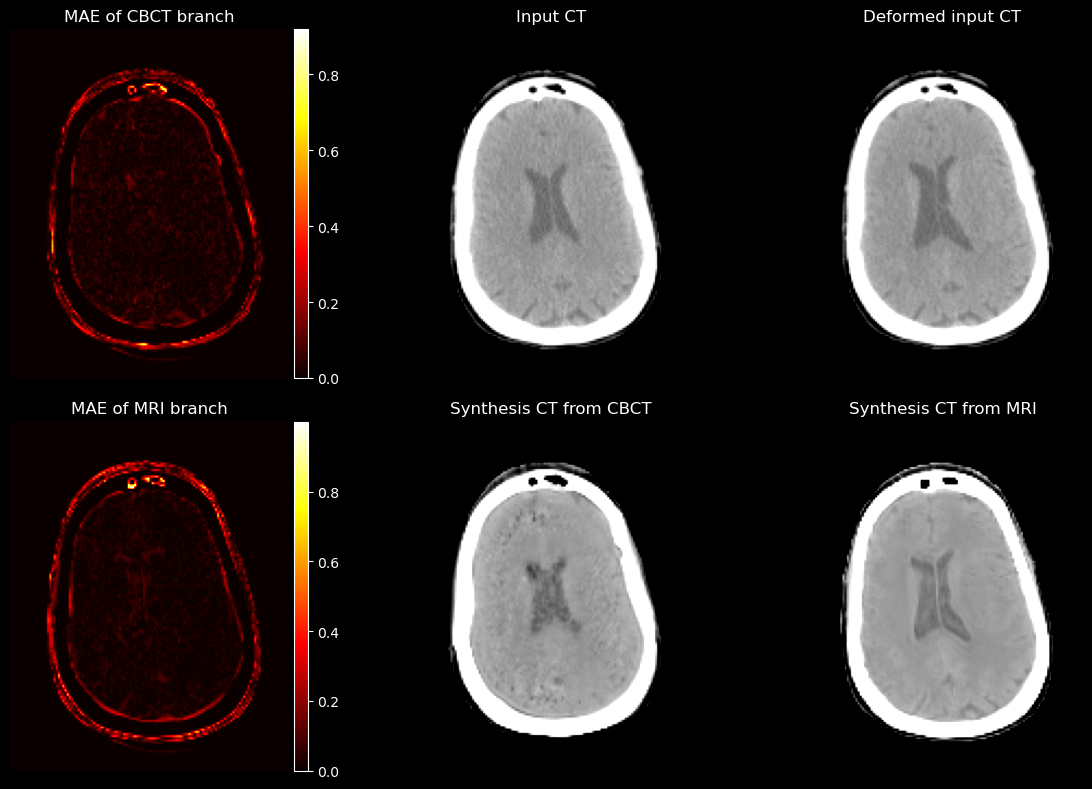

torch.Size([1, 7, 128, 160, 128])


100%|██████████| 10/10 [02:12<00:00, 13.20s/it]


In [9]:
import torch.nn.functional as F
metrics = pd.DataFrame()
mask_val = [1,2,23,5,19,29,8]
# valid_dataset = RadOncTrainingDataset("/home/myi16/jsr_Y/new_val", num_samples=10, transform=False,
#                                          supervision=True, return_segmentation=True)
l= len(valid_dataset)
print(len(valid_dataset))
for ep in range(1):
    G.load_state_dict(checkpoint['G_state_dict'])
    dice_before_total = []
    dice_after_total = []
    hd_before_total = []
    sd_before_total = []
    hd_after_total = []
    
    sd_after_total = []
    tre_before_total = []
    tre_after_total = []
    
    for i in tqdm(range(l)):
        cbct_fixed, mr_moving, ct_fixed, ct_moving, seg_fixed, seg_moving= valid_dataset[i]
        cbct_fixed = cbct_fixed.float().to(device)
        mr_moving = mr_moving.float().to(device)
        ct_fixed = ct_fixed.float().to(device)
        ct_moving = ct_moving.float().to(device)
        seg_fixed = seg_fixed.float().to(device)
        seg_moving = seg_moving.float().to(device)
        
        # mr_moving = mr_moving.unsqueeze(0).unsqueeze(0)
        # cbct_fixed = cbct_fixed.unsqueeze(0).unsqueeze(0)
        
        islice = 70
        islice_s = 68
        with torch.no_grad():
            # print(mr_moving.shape,cbct_fixed.shape)
            flow, ct_moving_synth, ct_fixed_synth= G(mr_moving, cbct_fixed)

            # the flow[0] means the final highest resolution from the cascade network.
            mr_reg = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(mr_moving, -flow[0])
            ct_reg_synth = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(ct_moving_synth[0], -flow[0])
            seg_reg = vxm.layers.SpatialTransformer([128,160,128], mode='nearest').to(device)(seg_moving, -flow[0])
            # mr_reg = mr_moving
            # seg_reg = seg_moving
            
            fig, ax = plt.subplots(2,3,figsize=(12,8))
            np.vectorize(lambda ax: ax.axis('off'))(ax)
            
            # ax[0, 1].imshow(mr_moving[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
            # ax[0, 1].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            # ax[0, 1].set_title('Pre-register MR under canny edges')
            
            # ax[0, 2].imshow(mr_reg[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
            # ax[0, 2].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            # ax[0, 2].set_title('Post-register MR under canny edges')
            
            # ax[1, 1].imshow(torch.flipud(mr_moving[0,0,islice_s,:,:].T), cmap='gray', vmin=0, vmax=0.4)
            # ax[1, 1].imshow(np.flipud(canny(ct_fixed.cpu().numpy()[islice,:,:].T, sigma=1)), cmap=colormap_binary('yellow', alpha=0.7))
            # ax[1, 1].set_title('Pre-register MR under canny edges')
            
            # ax[1, 2].imshow(torch.flipud(mr_reg[0,0,islice_s,:,:].T), cmap='gray', vmin=0, vmax=0.4)
            # ax[1, 2].imshow(np.flipud(canny(ct_fixed.cpu().numpy()[islice,:,:].T, sigma=1)), cmap=colormap_binary('yellow', alpha=0.7))
            # ax[1, 2].set_title('Post-register MR under canny edges')
            
            # fig, ax = plt.subplots(2,3,figsize=(12,8))
            # np.vectorize(lambda ax: ax.axis('off'))(ax)
            plt.style.use('dark_background')
            ax[0, 1].imshow(ct_fixed[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
            ax[0, 1].set_title('Input CT')
            
            ax[0, 2].imshow(ct_moving[:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
            ax[0, 2].set_title('Deformed input CT')
            
            ax[1, 1].imshow(ct_fixed_synth[0][0,0,:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
            ax[1, 1].set_title('Synthesis CT from CBCT')
            
            ax[1, 2].imshow(ct_moving_synth[0][0,0,:,:,islice].T, cmap='gray', vmin=0.2, vmax=0.95)
            ax[1, 2].set_title('Synthesis CT from MRI')
            
            imx1 = ax[0, 0].imshow(abs(ct_fixed_synth[0][0,0,:,:,islice]-ct_fixed[:,:,islice]).T, cmap='hot', vmin=0)
            ax[0, 0].set_title('MAE of CBCT branch')
            divider = make_axes_locatable(ax[0,0])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(imx1, cax=cax, orientation='vertical')
            
            imx2 = ax[1, 0].imshow(abs(ct_moving_synth[0][0,0,:,:,islice]-ct_moving[:,:,islice]).T, cmap='hot', vmin=0)
            ax[1, 0].set_title('MAE of MRI branch')
            divider = make_axes_locatable(ax[1,0])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(imx2, cax=cax, orientation='vertical')
            print(MIND((128,160,128),d=1, patch_size=7, use_gaussian_kernel=True,device = 'cpu').loss(ct_fixed_synth[0],ct_fixed_synth[0]),
                  MIND((128,160,128),d=1, patch_size=7, use_gaussian_kernel=True,device = 'cpu').loss(mr_moving,ct_moving.unsqueeze(0).unsqueeze(0)))
            
            # ax[1, 1].imshow(mr_moving[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
            # ax[1, 1].set_title('Input MR under canny edges')
            
            # ax[1, 2].imshow(mr_reg[0,0,:,:,islice].T, cmap='gray', vmin=0, vmax=0.4)
            # ax[1, 2].imshow(canny(ct_fixed.cpu().numpy()[:,:,islice].T, sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
            # ax[1, 2].set_title('Deformed MR under canny edges')           

            plt.tight_layout()
            plt.show()

            dice_before = []
            hd_before = []
            sd_before = []
            dice_after= []
            hd_after = []
            sd_after = []
            print(seg_fixed.shape)
            for j, val in enumerate(mask_val):
                mask_fixed = seg_fixed[:,j:j+1,:,:,:]
                mask_moving = seg_moving[:,j:j+1,:,:,:]
                mask_registered = seg_reg[:,j:j+1,:,:,:]
                dice_before.append(-losses.Dice().loss(mask_fixed,mask_moving).item())
                dice_after.append(-losses.Dice().loss(mask_fixed,mask_registered).item())
                metrics_before = compute_surface_metrics(np.squeeze(mask_fixed.squeeze().cpu().numpy())==1, np.squeeze(mask_moving.squeeze().cpu().numpy())==1)
                metrics_after = compute_surface_metrics(np.squeeze(mask_fixed.squeeze().cpu().numpy())==1, np.squeeze(mask_registered.squeeze().cpu().numpy())==1)
                hd_before.append(metrics_before['hd'])
                hd_after.append(metrics_after['hd'])
                sd_before.append(metrics_before['avg_dist'])
                sd_after.append(metrics_after['avg_dist'])
                
            dice_before_total.append(dice_before)
            dice_after_total.append(dice_after)
            hd_before_total.append(hd_before)
            hd_after_total.append(hd_after)
            sd_before_total.append(sd_before)
            sd_after_total.append(sd_after)
    if ep == 0:
        d0 = {'Dice':np.reshape(np.array(dice_before_total),-1), 'HD':np.reshape(np.array(hd_before_total),-1), 'SD':np.reshape(np.array(sd_before_total),-1), 
              'anatomy':['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']*l, 'ep':[0]*(7*l), 'method':['Rigid']*(7*l)}
        d0 = pd.DataFrame(data=d0)
        metrics = pd.concat([metrics, d0])

    d = {'Dice':np.reshape(np.array(dice_after_total),-1), 'HD':np.reshape(np.array(hd_after_total),-1), 'SD':np.reshape(np.array(sd_after_total),-1), 
         'anatomy':['3rd Ventricle', '4th Ventricle','Lateral Ventricles', 'Amygdala', 'Hippocampus', 'Thalamus', 'Caudate']*l, 'ep':[29+ep*10]*(7*l), 'method':['JSR-Cascade']*(7*l)}
    d = pd.DataFrame(data=d)
    metrics = pd.concat([metrics, d])